In [1]:
# Load the necessary packages.# Load  

import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
import progressbar
to_pil=ToPILImage()
%matplotlib inline
def load_image(path):
    image = Image.open(path) #convert LA is greyscale
    plt.imshow(image)
    plt.title("Image loaded successfully")
    plt.axis("off")
    return image

def preprocess_image(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Scale(28),
    transforms.Grayscale(),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze_(0), requires_grad=True)
    return image

In [2]:
# ReLU backward hook.

def relu_backward_deconv_hook(module,grad_in,grad_out):
     if isinstance(module, nn.ReLU):
        return (torch.clamp(grad_out[0], min=0.0),)
def Deconvolution(model):
    for m in model.modules():
        if isinstance(m,nn.ReLU):
            m.register_backward_hook(relu_backward_deconv_hook)

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
batch_sz = 1

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_sz,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=2)

classes = [i for i in range(10)]

    4


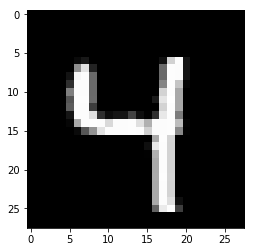

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [6]:
#https://github.com/pytorch/tutorials/blob/master/beginner_source/former_torchies/nn_tutorial.py

# -*- coding: utf-8 -*-
"""
nn package
==========
We’ve redesigned the nn package, so that it’s fully integrated with
autograd. Let's review the changes.
**Replace containers with autograd:**
    You no longer have to use Containers like ``ConcatTable``, or modules like
    ``CAddTable``, or use and debug with nngraph. We will seamlessly use
    autograd to define our neural networks. For example,
    * ``output = nn.CAddTable():forward({input1, input2})`` simply becomes
      ``output = input1 + input2``
    * ``output = nn.MulConstant(0.5):forward(input)`` simply becomes
      ``output = input * 0.5``
**State is no longer held in the module, but in the network graph:**
    Using recurrent networks should be simpler because of this reason. If
    you want to create a recurrent network, simply use the same Linear layer
    multiple times, without having to think about sharing weights.
    .. figure:: /_static/img/torch-nn-vs-pytorch-nn.png
       :alt: torch-nn-vs-pytorch-nn
       torch-nn-vs-pytorch-nn
**Simplified debugging:**
    Debugging is intuitive using Python’s pdb debugger, and **the debugger
    and stack traces stop at exactly where an error occurred.** What you see
    is what you get.
Example 1: ConvNet
------------------
Let’s see how to create a small ConvNet.
All of your networks are derived from the base class ``nn.Module``:
-  In the constructor, you declare all the layers you want to use.
-  In the forward function, you define how your model is going to be
   run, from input to output
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class MNISTConvNet(nn.Module):

    def __init__(self):
        # this is the place where you instantiate all your modules
        # you can later access them using the same names you've given them in
        # here
        super(MNISTConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)  
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(320, 50) #320
        self.fc2 = nn.Linear(50, 10)

    # it's the forward function that defines the network structure
    # we're accepting only a single input in here, but if you want,
    # feel free to use more
    def forward(self, input):
        x = self.pool1(F.relu(self.conv1(input)))
        x = self.pool2(F.relu(self.conv2(x)))

        # in your model definition you can go full crazy and use arbitrary
        # python code to define your model structure
        # all these are perfectly legal, and will be handled correctly
        # by autograd:
        # if x.gt(0) > x.numel() / 2:
        #      ...
        #
        # you can even do a loop and reuse the same module inside it
        # modules no longer hold ephemeral state, so you can use them
        # multiple times during your forward pass
        # while x.norm(2) < 10:
        #    x = self.conv1(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

###############################################################
# Let's use the defined ConvNet now.
# You create an instance of the class first.


net = torch.load('/Users/silver/Desktop/ucla_medical_imaging_informatics/dl4health_notebooks/deconvolution/vmnist.pt')
print(net)

#loading weights doesnt work for some reason
#net.load_state_dict(torch.load('/Users/silver/Desktop/ucla_medical_imaging_informatics/dl4health_notebooks/deconvolution/vmnist.pt'))
########################################################################
# .. note::
#
#     ``torch.nn`` only supports mini-batches The entire ``torch.nn``
#     package only supports inputs that are a mini-batch of samples, and not
#     a single sample.
#
#     For example, ``nn.Conv2d`` will take in a 4D Tensor of
#     ``nSamples x nChannels x Height x Width``.
#
#     If you have a single sample, just use ``input.unsqueeze(0)`` to add
#     a fake batch dimension.


MNISTConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
# # PRINTS FOR DAYS


# # #######################################################################
# # The output of the ConvNet ``out`` is a ``Tensor``. We compute the loss
# # using that, and that results in ``err`` which is also a ``Tensor``.
# # Calling ``.backward`` on ``err`` hence will propagate gradients all the
# # way through the ConvNet to it’s weights

# # Let's access individual layer weights and gradients:

# print("THIS IS CONV1 WEIGHT GRAD SIZE")
# print(net.conv1.weight.grad.size())

# print("THIS IS CONV1 WEIGHT GRAD")
# print(net.conv1.weight.grad)


# print("THIS IS POOL1 WEIGHT GRAD SIZE")
# print(net.pool1.weight.grad.size())

# print("THIS IS POOL1 WEIGHT GRAD")
# print(net.pool1.weight.grad)


# print("THIS IS CONV2 WEIGHT GRAD SIZE")
# print(net.conv2.weight.grad.size())

# print("THIS IS CONV2 WEIGHT GRAD")
# print(net.conv2.weight.grad)

# print("THIS IS FC1 WEIGHT GRAD SIZE")
# print(net.fc1.weight.grad.size())

# print("THIS IS FC1 WEIGHT GRAD")
# print(net.fc1.weight.grad)

# print("THIS IS FC2 WEIGHT GRAD SIZE")
# print(net.fc2.weight.grad.size())

# print("THIS IS FC2 WEIGHT GRAD")
# print(net.fc2.weight.grad)

GroundTruth:      9
None
tensor([[  0.0000,   0.0000,   0.4381,   1.9179,   7.4563,   3.7402,
           0.0000,   7.2065,   0.0000,  18.7825]])
2.182135904149618e-05
THIS IS GRAD
None


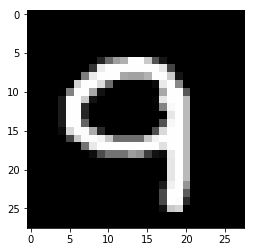

In [9]:

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))

#suppose i am interested in first layer
print(net.conv1.weight.grad)

outputs = net(images)#forward pass

print(outputs)
loss = criterion(outputs, labels)
print(loss.item())
print("THIS IS GRAD")
print(net.conv1.weight.data.grad)
#print(net.conv1.weight.data)


In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(1)))

Predicted:      9


In [45]:
# Deconvolution of image given the layer and number of filters to visualize.

def deconvolution(image,layer=0,num_filters = 0):
    
    # Get the submodel
    #vgg16_submodel=submodel(vgg16,last_layer)

    jq_m = copy.deepcopy(net)
    #jq_m = jq_m.load_state_dict(torch.load('/Users/silver/Desktop/net1_weight100ep.pt'))
    #someLayer = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    Deconvolution(jq_m)
    
    #Forward pass.
    #output=vgg16_submodel(image)
    output = jq_m(image)
    print(net.conv1.weight.data.grad)
    print(jq_m.conv1.weight.grad)
    
    oldGrad = copy.deepcopy(jq_m.conv1.weight.grad)
    print(oldGrad)
    #Zero out the existing gradient buffers.
    jq_m.zero_grad()

    
    print("THIS IS CONV1 WEIGHT AFTER ZERO GRAD")
    
    
    
#     someTensor = torch.Tensor(1,5,5,10)
#     print(someTensor)
    
#     print(jq_m)
#     print(jq_m.conv1)
#     print(jq_m.conv1.weight)
#     print(jq_m.conv1.weight.grad)
    
    counter = 0
    jq_m.conv1.weight.grad = torch.zeros(jq_m.conv1.weight.size())
    jq_m.conv1.weight.grad[9] = torch.ones(5,5)
            
    print(jq_m.conv1.weight.grad)
    gradients=[]
    #bar=progressbar.ProgressBar(max_value=num_filters)

    for filter_index in range(num_filters):

        #Progress indicator
        #bar.update(filter_index)

        #Calculate the loss.
        #loss=torch.max(output[0][filter_index])
        #loss = torch.max(output[0])
        loss = criterion(outputs,labels)
        print(loss)
        #Backward Pass
        loss.backward(retain_graph=True)


#         #Visualize the gradient image
#         image.grad.data=image.grad.data-image.grad.data.min()
#         image.grad.data/=(image.grad.data.max()-image.grad.data.min())
#         grads=image.grad.data.squeeze(0)
#         grads.transpose_(0,1) #don't use permute.
#         grads.transpose_(1,2)
#         gradients.append(grads)

#     fig=plt.figure(figsize=(30,30),facecolor='black')    
#     for i in range(int(np.sqrt(num_filters))*int(np.sqrt(num_filters))):
#         a=fig.add_subplot(np.sqrt(num_filters),np.sqrt(num_filters), i+1)
#         a.imshow(gradients[i])
#         a.axis('off')
#         plt.subplots_adjust(hspace=0.01,wspace=0.01,left=0.01,bottom=0.01)
   # plt.savefig('/Users/silver/Desktop/deconvs/Deconvolution.jpg',facecolor=fig.get_facecolor(),bbox_inches='tight')

/Users/silver/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


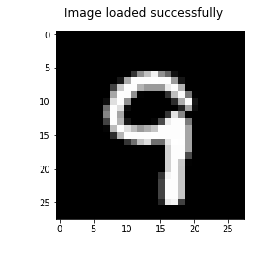

In [46]:
# Deconvolution visualization of a cat.

cat=load_image("/Users/silver/Desktop/ucla_medical_imaging_informatics/dl4health_notebooks/deconvolution/9.png")
cat=preprocess_image(cat)

#print(cat)

In [47]:
deconvolution(cat,1,10)

None
None
None
THIS IS CONV1 WEIGHT AFTER ZERO GRAD
tensor([[[[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.]]],


   